In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Benji
! ls

/content/drive/MyDrive/Colab Notebooks/Benji
 a1_IMDB_Dataset.csv    a3_IMDb_Unseen_Reviews.csv	 lstm_model.h5
 a2_glove.6B.100d.txt   c2_IMDb_Unseen_Predictions.csv	'Modulo 2.ipynb'


In [ ]:
!pip install tensorflow

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [ ]:
# Importar el dataset de las reviews de IMDB
movie_reviews = pd.read_csv('a1_IMDB_Dataset.csv')

# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

print(movie_reviews.shape)
movie_reviews.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
movie_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


<Axes: xlabel='sentiment', ylabel='count'>

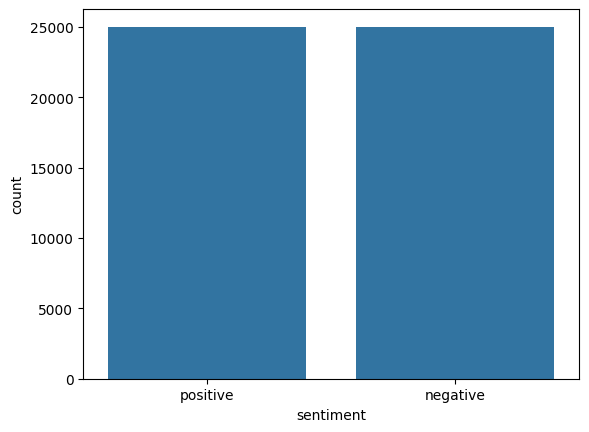

In [ ]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

In [ ]:
# Replace HTML tags with white space
tag = re.compile(r'<[^>]+>')

def remove_tags(text):
  return tag.sub('', text)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def preprocess_text(t):
  text = t.lower()

  # Call the HTML tags remove function
  text = remove_tags(text)

  # Remove non alphabetical characters
  text = re.sub('[^a-zA-Z]', ' ', text)

  # Single character removal
  text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

  # Remove multiple spaces
  text = re.sub(r"\s+", ' ', text)

  # Remove stopwords
  pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  text = pattern.sub('', text)

  return text

In [ ]:
# Call preprocess_text function on the reviews

X = []
for i in range(movie_reviews.shape[0]):
  X.append(preprocess_text(movie_reviews.iloc[i][0]))

<ipython-input-15-8a62f306268b>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X.append(preprocess_text(movie_reviews.iloc[i][0]))


In [ ]:
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [ ]:
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, movie_reviews['sentiment'])))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
vocab_size = len(word_tokenizer.word_index) + 1

vocab_size

92394

In [ ]:
max_len = 100

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

In [ ]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:], dtype='float32')
  embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))

for word, index in word_tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [ ]:
from tensorflow.keras.layers import Conv1D

In [ ]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_len, trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

In [ ]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - acc: 0.6803 - loss: 0.5970 - val_acc: 0.8356 - val_loss: 0.3802
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 95ms/step - acc: 0.8509 - loss: 0.3477 - val_acc: 0.8486 - val_loss: 0.3457
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - acc: 0.8878 - loss: 0.2792 - val_acc: 0.8449 - val_loss: 0.3511
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 106ms/step - acc: 0.9189 - loss: 0.2208 - val_acc: 0.8487 - val_loss: 0.3509
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - acc: 0.9519 - loss: 0.1574 - val_acc: 0.8521 - val_loss: 0.3580
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - acc: 0.9769 - loss: 0.1015 - val_acc: 0.8522 - val_loss: 0.3762


In [ ]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.8422 - loss: 0.3881


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.39631596207618713
Test Accuracy: 0.8422999978065491


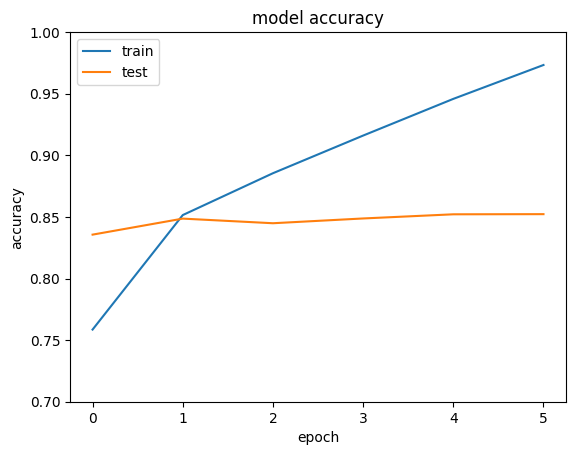

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0.7,1)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


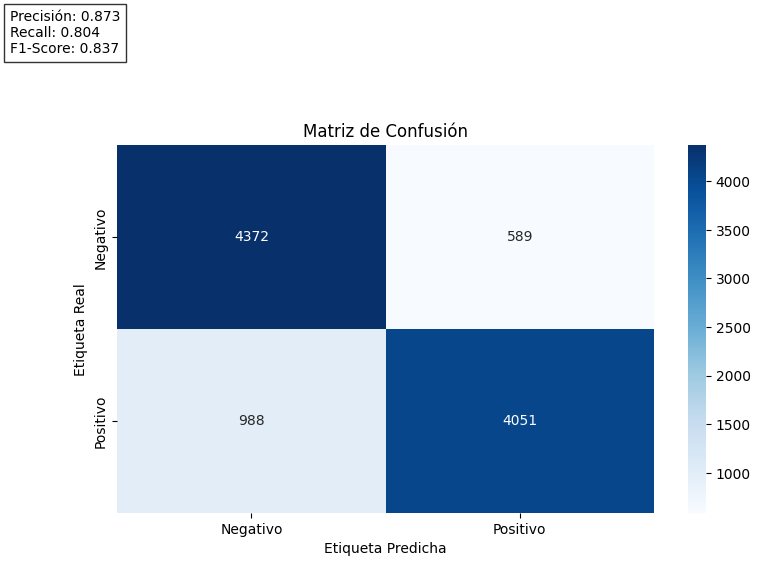


Métricas detalladas:
Verdaderos Negativos (TN): 4372
Falsos Positivos (FP): 589
Falsos Negativos (FN): 988
Verdaderos Positivos (TP): 4051

Precisión: 0.873
Recall: 0.804
F1-Score: 0.837


In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Obtener las predicciones
y_pred = cnn_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Crear la visualización
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])

plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')

# Calcular métricas adicionales
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Añadir texto con métricas adicionales
plt.text(-0.4, -0.5, f'Precisión: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1_score:.3f}',
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Imprimir las métricas detalladas
print("\nMétricas detalladas:")
print(f"Verdaderos Negativos (TN): {tn}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Falsos Negativos (FN): {fn}")
print(f"Verdaderos Positivos (TP): {tp}")
print(f"\nPrecisión: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1_score:.3f}")

# Recurrent Neural Network (LSTM)

In [ ]:
from keras.layers import LSTM

In [ ]:
lstm_model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_len, trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

In [ ]:
# Train the model
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 93s 360ms/step - acc: 0.6565 - loss: 0.6106 - val_acc: 0.8050 - val_loss: 0.4399
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 131s 317ms/step - acc: 0.7942 - loss: 0.4509 - val_acc: 0.8282 - val_loss: 0.3846
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 314ms/step - acc: 0.8326 - loss: 0.3841 - val_acc: 0.8291 - val_loss: 0.3891
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 315ms/step - acc: 0.8502 - loss: 0.3491 - val_acc: 0.8618 - val_loss: 0.3309
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 116s 451ms/step - acc: 0.8637 - loss: 0.3260 - val_acc: 0.8581 - val_loss: 0.3256
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 320ms/step - acc: 0.8724 - loss: 0.3042 - val_acc: 0.8676 - val_loss: 0.3125


In [ ]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - acc: 0.8670 - loss: 0.3135


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3156546652317047
Test Accuracy: 0.8654000163078308


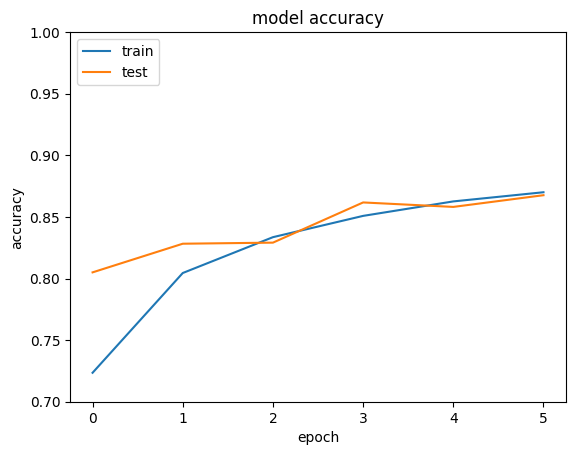

In [ ]:
plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0.7,1)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step


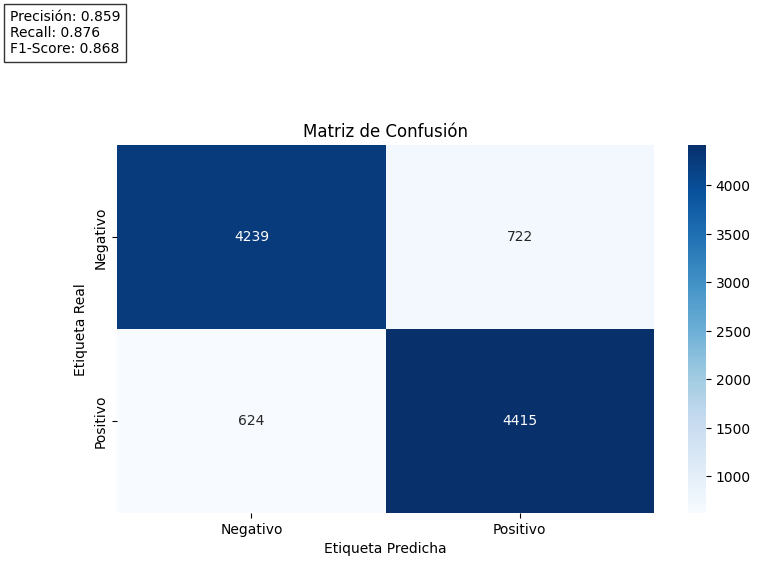


Métricas detalladas:
Verdaderos Negativos (TN): 4239
Falsos Positivos (FP): 722
Falsos Negativos (FN): 624
Verdaderos Positivos (TP): 4415

Precisión: 0.859
Recall: 0.876
F1-Score: 0.868


In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Obtener las predicciones
y_pred = lstm_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Crear la visualización
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])

plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')

# Calcular métricas adicionales
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Añadir texto con métricas adicionales
plt.text(-0.4, -0.5, f'Precisión: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1_score:.3f}',
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Imprimir las métricas detalladas
print("\nMétricas detalladas:")
print(f"Verdaderos Negativos (TN): {tn}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Falsos Negativos (FN): {fn}")
print(f"Verdaderos Positivos (TP): {tp}")
print(f"\nPrecisión: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1_score:.3f}")

In [ ]:
lstm_model.save('lstm_model.h5', save_format='h5')

In [ ]:
sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")
sample_reviews

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Inside Out,Pixar has done it again with this wonderfully ...,9.0
1,1,The Shawshank Redemption,"This film is a powerful story of hope, friends...",10.0
2,2,Inception,Inception is a groundbreaking film that delves...,9.0
3,3,The Godfather,Francis Ford Coppola's The Godfather is widely...,9.0
4,4,The Dark Knight,The Dark Knight redefined the superhero genre ...,9.0
...,...,...,...,...
125,124,Star Wars: A New Hope,Star Wars: A New Hope felt dated and underwhel...,5.0
126,125,Avatar,Avatar didn’t live up to the immense hype it r...,4.0
127,126,Deadpool,Deadpool was more annoying than entertaining. ...,5.0
128,127,The Godfather,The Godfather was a slog for me. Despite the p...,6.0


In [ ]:
unseen_reviews = sample_reviews['Review Text']

unseen_processed_reviews = []

for review in unseen_reviews:
  unseen_processed_reviews.append(preprocess_text(review))

In [ ]:
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed_reviews)
unseen = pad_sequences(unseen_tokenized, padding='post', maxlen=max_len)

In [ ]:
unseen_sentiments = lstm_model.predict(unseen)
unseen_sentiments

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


array([[0.9791397 ],
       [0.9797592 ],
       [0.9764846 ],
       [0.9797204 ],
       [0.9796121 ],
       [0.97708875],
       [0.9793577 ],
       [0.9771909 ],
       [0.97875   ],
       [0.98013496],
       [0.97974986],
       [0.97596043],
       [0.9778848 ],
       [0.974233  ],
       [0.9703596 ],
       [0.97339815],
       [0.9774701 ],
       [0.9781528 ],
       [0.9723326 ],
       [0.97844434],
       [0.97628343],
       [0.97849715],
       [0.9783253 ],
       [0.97831714],
       [0.9776609 ],
       [0.97769755],
       [0.97395784],
       [0.8842532 ],
       [0.975754  ],
       [0.9732903 ],
       [0.9436927 ],
       [0.9758316 ],
       [0.59691674],
       [0.97701806],
       [0.97655326],
       [0.9767144 ],
       [0.97873557],
       [0.9624405 ],
       [0.9738826 ],
       [0.02038357],
       [0.9782368 ],
       [0.9674604 ],
       [0.97888106],
       [0.97364783],
       [0.9734973 ],
       [0.02032025],
       [0.96359146],
       [0.969

In [ ]:
sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments *10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns=['Predicted Sentiments'])
df_movie = pd.DataFrame(sample_reviews['Movie'], columns=['Movie'])
df_review = pd.DataFrame(sample_reviews['Review Text'], columns=['Review Text'])
df_imdb_rating = pd.DataFrame(sample_reviews['IMDb Rating'], columns=['IMDb Rating'])

dfx = pd.concat([df_movie, df_review, df_imdb_rating, df_prediction_sentiments], axis=1)
dfx.to_csv('./c2_IMDb_Unseen_Predictions.csv', sep=',', encoding="UTF-8")

dfx

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Inside Out,Pixar has done it again with this wonderfully ...,9.0,9.8
1,The Shawshank Redemption,"This film is a powerful story of hope, friends...",10.0,9.8
2,Inception,Inception is a groundbreaking film that delves...,9.0,9.8
3,The Godfather,Francis Ford Coppola's The Godfather is widely...,9.0,9.8
4,The Dark Knight,The Dark Knight redefined the superhero genre ...,9.0,9.8
...,...,...,...,...
125,Star Wars: A New Hope,Star Wars: A New Hope felt dated and underwhel...,5.0,9.5
126,Avatar,Avatar didn’t live up to the immense hype it r...,4.0,6.0
127,Deadpool,Deadpool was more annoying than entertaining. ...,5.0,8.1
128,The Godfather,The Godfather was a slog for me. Despite the p...,6.0,3.2


In [ ]:
print(dfx['Movie'].unique())

['Inside Out' 'The Shawshank Redemption' 'Inception' 'The Godfather'
 'The Dark Knight' "Schindler's List" 'Forrest Gump' 'Parasite'
 'Toy Story' 'The Lord of the Rings: The Fellowship of the Ring'
 'Gladiator' 'Eternal Sunshine of the Spotless Mind' 'La La Land'
 'The Pursuit of Happyness' 'Her' 'Interstellar' 'Review Text'
 'The Matrix' 'The Revenant' 'The Social Network' 'A Beautiful Mind'
 'The Twilight Saga' 'Donnie Darko' 'Blade Runner 2049' 'Gravity'
 'Memento' 'Suicide Squad' 'The Lion King' 'Fifty Shades of Grey' 'Avatar'
 'The Room' 'Star Wars: The Force Awakens' 'Shutter Island'
 'The Hobbit: An Unexpected Journey' 'Jurassic World' 'The Princess Bride'
 'Avengers: Endgame' 'Ex Machina' 'Deadpool' 'Citizen Kane'
 'The Blair Witch Project' 'The Godfather Part II' 'The Hunger Games'
 'Titanic' 'Avengers: Infinity War' 'Transformers' 'Goodfellas'
 'The Great Gatsby' 'Spider-Man: No Way Home' 'The Dark Knight Rises'
 'The Lion King (2019)' 'Fight Club' 'A Quiet Place' 'Shrek'
 'N

In [ ]:
# Busca la fila que corresponde a la película
movie_name = "Gladiator"
movie_row = dfx[dfx['Movie'] == movie_name]
if movie_row.empty:
    print(f"La película '{movie_name}' no se encuentra en el conjunto de datos.")
else:
  print(movie_row)

         Movie                                        Review Text  \
10   Gladiator  Ridley Scott’s Gladiator is a riveting tale of...   
21   Gladiator  Gladiator was an exhilarating and emotionally ...   
87   Gladiator  Gladiator left me feeling both inspired and em...   
108  Gladiator  Gladiator left me feeling a mix of anger and s...   

     IMDb Rating  Predicted Sentiments  
10           8.0                   9.8  
21           8.0                   9.8  
87           8.0                   3.7  
108          8.0                   9.8  


# Next Steps
## Mini app
Esta mini app te permite ingresar tu propia review o consultar las reviews de una pelicula en especifco

In [ ]:
# Funcion para predecir la calificacion de una review a partir del texto de la review
def predict_sentiment(review_text):
    processed_review = preprocess_text(review_text)
    tokenized_review = word_tokenizer.texts_to_sequences([processed_review])
    padded_review = pad_sequences(tokenized_review, padding='post', maxlen=max_len)
    predicted_sentiment = lstm_model.predict(padded_review)

    sentiment = ""
    if predicted_sentiment > 0.5:
        sentiment = "positive"
    else:
        sentiment = "negative"
    return sentiment,np.round(predicted_sentiment[0][0] * 10, 1)

# Funcion para recibir los inputs del usuario
def create_review():
    movie_name = input("Enter the name of the movie: ")
    review_text = input("Write your review: ")
    user_rating = float(input("Enter your rating (from 1 to 10): "))

    predicted_rating = predict_sentiment(review_text)
    print(f"Your rating: {user_rating}")
    print(f"The review's author sentiment is: {predicted_rating[0]}")
    print(f"Predicted rating by the model: {predicted_rating[1]}")

# Funcion para buscar una pelicula y mostrar sus reviews
def search_movie():
    movie_name = input("Enter the name of the movie you want to search: ")
    movie_row = dfx[dfx['Movie'] == movie_name]
    if movie_row.empty:
        print(f"The movie '{movie_name}' is not in the dataset.")
    else:
        print(movie_row)

# Funcion para empezar la mini app
def mini_app():
    print("Welcome to the Reviews Mini App")
    print("Select an option:")
    print("1. Create your own review and compare rating")
    print("2. Search reviews for a specific movie")

    option = input("Enter option (1 or 2): ")

    if option == '1':
        create_review()
    elif option == '2':
        search_movie()
    else:
        print("Invalid option. Please enter 1 or 2.")

mini_app()


Welcome to the Reviews Mini App
Select an option:
1. Create your own review and compare rating
2. Search reviews for a specific movie
Enter option (1 or 2): 1
Enter the name of the movie: Overlord
Write your review: I just don't know, could have been better, but it really wasn't my cup of tea
Enter your rating (from 1 to 10): 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Your rating: 3.0
The review's author sentiment is: positive
Predicted rating by the model: 9.1
